**We fetch the data**

We select one city to start with

In [1662]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
data = pd.read_csv('listings_stockholm.csv.gz', nrows=13815, compression='gzip')

data = data[['accommodates','bathrooms_text','bedrooms', 'beds', 'review_scores_rating','review_scores_location','review_scores_value','reviews_per_month','number_of_reviews','calculated_host_listings_count','minimum_nights','availability_90','amenities','property_type','room_type','price']]

# data = data[['accommodates','bedrooms','price']]
data = data.dropna()
data.shape



(2974, 16)

**We define a function to change string features to an integer**

In [1663]:
def string_features_to_num(array):
    dictOfWords = { i : np.unique(array)[i] for i in range(0, len(np.unique(array)) ) }
    dictOfWords = {v: k for k, v in dictOfWords.items()}
    
    values = np.zeros(len(array))
    for i in range(len(array)):
        values[i] = dictOfWords.get(array[i])
        
    return values, dictOfWords

In [1664]:
def selectPropertyType(type, X, y):
    xlist = []
    ylist = []
    for i in range(X.shape[0]):
        if(X[i,-2] == type):
            xlist.append(X[i,:])
            ylist.append(y[i])
    return np.array(xlist), np.array(ylist)

In [1665]:
def oneHotEncodingPropertyType(type, X):
    isType = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        if(X[i,-2] == type):
            isType[i] = 1.0
    return np.hstack((X, isType.reshape(-1,1)))

**Data split into features and target**

We also change the target from a string to a float. 

In [1666]:
import re

datanp = np.array(data)
X = datanp[:,:-1]
y = datanp[:,-1]

bathroomErr = []
for i in range(X.shape[0]):
    try:
        X[i,1] = float(X[i,1].split()[0])
    except ValueError:
        bathroomErr.append(i)
bathroomErr = np.array(bathroomErr)
X = np.delete(X, bathroomErr, axis=0)
y = np.delete(y, bathroomErr)

for i in range(len(y)):
    y[i] = float(re.sub(",", "", (y[i][1:])))



X[:, -2], propertytype_dict = string_features_to_num(X[:, -2])
X[:, -1], roomtype_dict = string_features_to_num(X[:, -1])

print(propertytype_dict)
print(list(enumerate(np.bincount(np.array(X[:, -2],dtype='int64')))))

X, y = selectPropertyType(propertytype_dict.get('Entire rental unit'), X, y)

X = X[:,:X.shape[1]-2]

# X = oneHotEncodingPropertyType(propertytype_dict.get('Entire rental unit'), X)
# X = oneHotEncodingPropertyType(propertytype_dict.get('Entire condo'), X)
# X = oneHotEncodingPropertyType(propertytype_dict.get('Private room in rental unit'), X)

X.shape


{'Boat': 0, 'Entire bungalow': 1, 'Entire cabin': 2, 'Entire condo': 3, 'Entire cottage': 4, 'Entire guest suite': 5, 'Entire guesthouse': 6, 'Entire home': 7, 'Entire in-law': 8, 'Entire loft': 9, 'Entire place': 10, 'Entire rental unit': 11, 'Entire serviced apartment': 12, 'Entire townhouse': 13, 'Entire vacation home': 14, 'Entire villa': 15, 'Private room': 16, 'Private room in bed and breakfast': 17, 'Private room in boat': 18, 'Private room in casa particular': 19, 'Private room in condo': 20, 'Private room in guest suite': 21, 'Private room in guesthouse': 22, 'Private room in home': 23, 'Private room in hostel': 24, 'Private room in houseboat': 25, 'Private room in loft': 26, 'Private room in rental unit': 27, 'Private room in serviced apartment': 28, 'Private room in townhouse': 29, 'Private room in vacation home': 30, 'Private room in villa': 31, 'Room in aparthotel': 32, 'Room in bed and breakfast': 33, 'Room in boutique hotel': 34, 'Room in hostel': 35, 'Room in hotel': 36

(1256, 13)

In [1667]:
import ast 

def amenitiesOneHot(X, amenityName):
    amenities = []
    for i in range(X.shape[0]):
        amenities.append(ast.literal_eval(X[i,-1]))

    amenity = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(len(amenities[i])):
            if(amenities[i][j]==amenityName):
                amenity[i] = 1
    return amenity

**One Hot encoded features added**

In [1668]:
# np.sum(amenitiesOneHot(X, 'Private patio or balcony'))/X.shape[0]


patio = amenitiesOneHot(X, 'Private patio or balcony')
tv = amenitiesOneHot(X, 'TV')
wifi = amenitiesOneHot(X, 'Wifi')
onehot = np.hstack((tv.reshape(-1,1), patio.reshape(-1,1)))
onehot = np.hstack((onehot, wifi.reshape(-1,1)))

X = X[:,:-1]
X = np.hstack((X, onehot))
X.shape

(1256, 15)

**Data split into train/val/test**

In [1669]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

**Models imported**

In [1670]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_model = LinearRegression()
svr_model = SVR(C=60, epsilon=0.95)

**Models fit and scored**

We fit the models on the training set and test with the linear regression. 

In [1671]:
linear_model.fit(X_train, y_train)
linear_train_score = linear_model.score(X_train, y_train)
linear_val_score = linear_model.score(X_val,y_val)
linear_test_score = linear_model.score(X_test,y_test)

print("Training score: ", linear_train_score)
print("Test score: ", linear_test_score)
print("Validation score: ", linear_val_score)

Training score:  0.31145369358920694
Test score:  0.24615286464967467
Validation score:  0.21955217205770783


In [1672]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



In [1673]:
from sklearn.svm import NuSVR

svr_model = NuSVR(C=600, nu=0.3)
svr_model.fit(X_train, y_train)
svr_train_score = svr_model.score(X_test, y_test)
svr_test_score = svr_model.score(X_test, y_test)
svr_val_score = svr_model.score(X_test, y_test)
print("Training score: ", svr_train_score)
print("Test score: ", svr_test_score)
print("Validation score: ", svr_val_score)


Training score:  0.3853238704539046
Test score:  0.3853238704539046
Validation score:  0.3853238704539046


In [1674]:
from sklearn.ensemble import RandomForestRegressor

regr_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=100)
regr_model.fit(X_train, y_train)

regr_train_score = regr_model.score(X_test, y_test)
regr_test_score = regr_model.score(X_test, y_test)
regr_val_score = regr_model.score(X_test, y_test)

print("Training score: ", regr_train_score)
print("Test score: ", regr_test_score)
print("Validation score: ", regr_val_score)


Training score:  0.27582564169812096
Test score:  0.27582564169812096
Validation score:  0.27582564169812096


In [1675]:
from sklearn.linear_model import Ridge


clf_model = Ridge(alpha=5)
clf_model.fit(X_train, y_train)

clf_train_score = clf_model.score(X_test, y_test)
clf_test_score = clf_model.score(X_test, y_test)
clf_val_score = clf_model.score(X_test, y_test)

print("Training score: ", clf_train_score)
print("Test score: ", clf_test_score)
print("Validation score: ", clf_val_score)

Training score:  0.24927434432678686
Test score:  0.24927434432678686
Validation score:  0.24927434432678686



Training r2: 0.9991
Validation r2: -0.1013


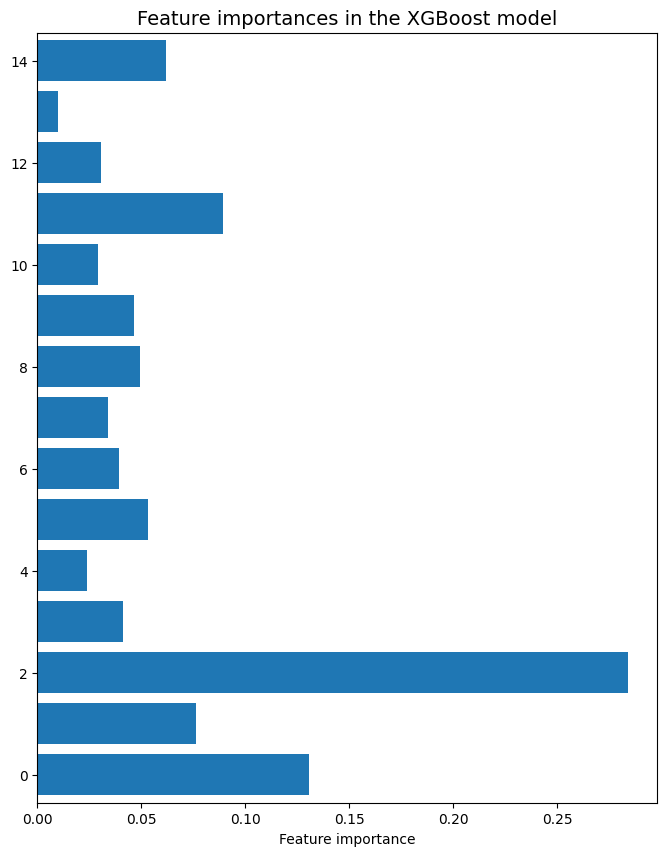

In [1676]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import xgboost as xgb



X_train = pd.DataFrame(X_train, dtype='float')
X_test = pd.DataFrame(X_test, dtype='float')
y_train = pd.DataFrame(y_train, dtype='float')
y_test = pd.DataFrame(y_test, dtype='float')

# Fitting the model
# learning_rate=0.12, max_depth=4, n_estimators=20
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,10))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [1677]:
# import math
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.losses import MeanSquaredLogarithmicError
# from sklearn.metrics import r2_score

# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

# def scale_datasets(x_train, x_test):
#     """
#     Standard Scale test and train data
#     Z - Score normalization
#     """
#     standard_scaler = StandardScaler()
#     x_train_scaled = pd.DataFrame(
#         standard_scaler.fit_transform(x_train),
#         columns=x_train.columns
#     )
#     x_test_scaled = pd.DataFrame(
#         standard_scaler.transform(x_test),
#         columns = x_test.columns
#     )
#     return x_train_scaled, x_test_scaled
# x_train_scaled, x_test_scaled = scale_datasets(X_train, X_test)

In [1678]:
# hidden_units1 = 160
# hidden_units2 = 480
# hidden_units3 = 256
# learning_rate = 5e-3
# # Creating model using the Sequential in tensorflow
# def build_model_using_sequential():
#   model = Sequential([
#     Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
#     Dropout(0.2),
#     Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
#     Dense(1, kernel_initializer='normal', activation='linear')
#   ])
#   return model
# # build the model
# model = build_model_using_sequential()

In [1679]:
# # loss function
# msle = MeanSquaredLogarithmicError()
# model.compile(
#     loss=msle, 
#     optimizer=Adam(learning_rate=learning_rate), 
#     metrics=[msle]
# )
# # train the model
# history = model.fit(
#     x_train_scaled.values, 
#     np.asarray(y_train.values).astype('float32'), 
#     epochs=20, 
#     batch_size=8,
#     validation_split=0.2
# )

In [1680]:
# def plot_history(history, key):
#   plt.plot(history.history[key])
#   plt.plot(history.history['val_'+key])
#   plt.xlabel("Epochs")
#   plt.ylabel(key)
#   plt.legend([key, 'val_'+key])
#   plt.show()
# # Plot the history
# plot_history(history, 'mean_squared_logarithmic_error')

# X_test['prediction'] = model.predict(x_test_scaled)

# r2_score(y_test, model.predict(x_test_scaled))
